In [1]:
%matplotlib inline

from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.fft import fft2, ifft2, fftshift, fftfreq
from bruges.transform import time_to_depth
from scipy.interpolate import CubicSpline, interp1d, interp2d
from scipy.signal import coherence
import ipywidgets as ipw
from ipywidgets import Layout, Label

# sns.set_style(style='ticks')


In [2]:
def nmo_correction(cmp, dt, offsets, velocities):
    """
    Performs NMO correction on the given CMP.
    
    The units must be consistent. E.g., if dt is seconds and
    offsets is meters, velocities must be m/s.
    
    Parameters
    ----------
    
    cmp : 2D array
        The CMP gather that we want to correct.
    dt : float
        The sampling interval.
    offsets : 1D array
        An array with the offset of each trace in the CMP.
    velocities : 1D array
        An array with the NMO velocity for each time. Should
        have the same number of elements as the CMP has samples.
        
    Returns
    -------
    
    nmo : 2D array
        The NMO corrected gather.
        
    """
    nmo = np.zeros_like(cmp)
    nsamples = cmp.shape[0]
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, x in enumerate(offsets):
            t = reflection_time(t0, x, velocities[i])
            amplitude = sample_trace(cmp[:, j], t, dt)
            # If the time t is outside of the CMP time range,
            # amplitude will be None.
            if amplitude is not None:
                nmo[i, j] = amplitude
    return nmo

In [3]:
def reflection_time(t0, x, vnmo):
    """
    Calculate the travel-time of a reflected wave.
    
    Doesn't consider refractions or changes in velocity.
        
    The units must be consistent. E.g., if t0 is seconds and
    x is meters, vnmo must be m/s.
    
    Parameters
    ----------
    
    t0 : float
        The 0-offset (normal incidence) travel-time.
    x : float
        The offset of the receiver.
    vnmo : float
        The NMO velocity.
        
    Returns
    -------
    
    t : float
        The reflection travel-time.
        
    """
    t = np.sqrt(t0**2 + x**2/vnmo**2)
    return t

In [4]:
def sample_trace(trace, time, dt):
    """
    Sample an amplitude at a given time using interpolation.
    
    Parameters
    ----------
    
    trace : 1D array
        Array containing the amplitudes of a single trace.
    time : float
        The time at which I want to sample the amplitude.
    dt : float
        The sampling interval
        
    Returns
    -------
    
    amplitude : float or None
        The interpolated amplitude. Will be None if *time*
        is beyond the end of the trace or if there are less
        than 2 points between *time* and the end.
        
    """
    # The floor function will give us the integer
    # right behind a given float.
    # Use it to get the sample number that is right
    # before our desired time.
    before = int(np.floor(time/dt))
    N = trace.size
    # Use the 4 samples around time to interpolate
    samples = np.arange(before - 1, before + 3)
    if any(samples < 0) or any(samples >= N):
        amplitude = None
    else:
        times = dt*samples
        amps = trace[samples]
        interpolator = CubicSpline(times, amps)
        amplitude = interpolator(time)
    return amplitude

#### Load in our synthetic CMP with known velocity model
Note: The geometrical spreading correction here was to simply multiply the CMP by TWT value

In [5]:
# data2 = np.load(r'C:/Users/goril/OneDrive/_data/cmp_info_2.npz')
data = np.load(r'C:/Users/goril/OneDrive/_data/cmp_info_2200m.npz')
print(f'Data in the archive {data.keys()}')

Data in the archive ['velocity_model', 'density_model', 'offsets', 'cmp_orig', 'cmp_geom_sprd', 'dz', 'dt', 'reciever_loc', 'shot_loc', 'twt', 'vnmo_trials', 'vnmo_trial_vels']


In [6]:
cmp_vel_mod = data['velocity_model']
cmp_orig = data['cmp_orig']
cmp_density_mod = data['density_model']
dz = data['dz']
dt = data['dt']
shot_loc = data['shot_loc']
offsets = data['offsets']
reciever_loc = data['reciever_loc']
twt = data['twt']
vnmo_trials = data['vnmo_trials'] 
vnmo_trial_vels = data['vnmo_trial_vels']


# twt = np.linspace(0,len(cmp_orig) * dt, len(cmp_orig))
cmp_geom_sprd = cmp_orig * twt.reshape(len(twt), 1)

lim_geom = np.percentile(cmp_geom_sprd, 99)
lim_cmp = np.percentile(cmp_orig, 99)

In [7]:
# np.savez('C:/Users/goril/OneDrive/_data/cmp_info_2200m.npz', velocity_model = cmp_vel_mod, density_model = cmp_density_mod,
#          offsets=offsets, cmp_orig = cmp_orig, cmp_geom_sprd=cmp_geom_sprd, dz=dz,dt=dt,reciever_loc=reciever_loc,
#          shot_loc=shot_loc,twt=twt, vnmo_trials=vnmo_trials, vnmo_trial_vels=vnmo_trial_vels)

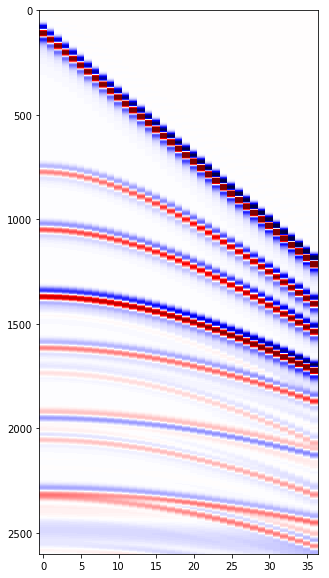

In [8]:
twt = np.linspace(0,len(cmp_orig) * dt, len(cmp_orig))
cmp_geom_sprd = cmp_orig * twt.reshape(2600,1)
plt.figure(figsize=(5,10))
plt.imshow(cmp_geom_sprd, aspect='auto', cmap='seismic', vmin=-lim_geom, vmax=lim_geom)

In [7]:
def fk_filt_plot(cmp_arr, upper_lim, offsets, dt):
    n = cmp_arr.shape[0]
    N = cmp_arr.shape[1]
    L = offsets[-1]
    cmp_extent = [0,offsets.max(),len(cmp_arr)*dt,0]
    lim_cmp = np.percentile(cmp_arr, 99)
    twt = np.linspace(0, len(cmp_arr) * dt, len(cmp_arr))
    gain = 5
    
    
    x = fft2(cmp_arr)
    x_shift = fftshift(x)
    power = np.abs(x_shift)
    color_lim = np.percentile(power, 99.93)
    plot_lim = power.shape[0] / 2
    freqs = fftfreq(n, dt)
    n_value = fftfreq(N, 1/N) # creating a basis for the wavenumber values
    k = [2.0 * np.pi * n_val / L for n_val in n_value] # calculating the wavenumbers
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
    
    ax1.imshow(cmp_geom_sprd, cmap='gray', vmin=-lim_cmp, vmax=lim_cmp, aspect='auto',
          extent=cmp_extent,interpolation='lanczos')
        
    ax1.set_xlabel('Offset (m)', size=12)
    ax1.set_ylabel('TWT (s)', size=12)
    ax1.set_title(f'T-X domain: {np.diff(offsets)[0]} m trace spacing', size = 18)
    # multiply by 1e3 to go from cycles/m to cycles/km 
    ax2.imshow(power[int(plot_lim -upper_lim):int(plot_lim)], vmin=0, vmax=color_lim, cmap='plasma', aspect = 'auto',
              extent=[np.min(k) * 1e3,np.max(k) * 1e3,0,freqs[upper_lim]], interpolation='lanczos')
    ax2.set_title('F-K domain', size=18)
    ax2.set_ylabel(r'Frequency ($f:$ Hz)', size=12)
    ax2.set_xlabel(r'Wavenumber ($k:$ $\frac{cycles}{km}$)', size = 12)
    plt.tight_layout()
    return freqs, k, L
    

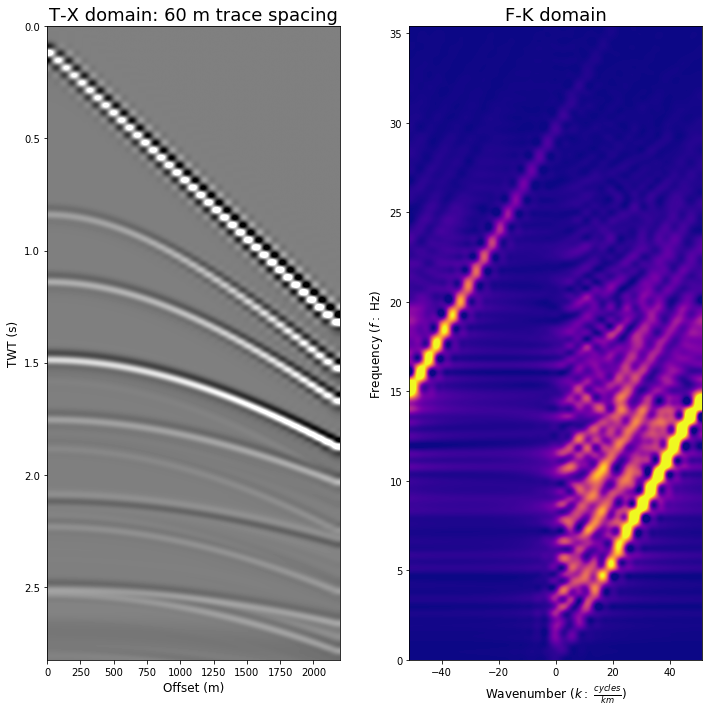

In [8]:
freqs, k , L = fk_filt_plot(cmp_geom_sprd, 100, offsets,dt)

#### The above F-K domain plot shows that we are spatially aliased above 15 Hz because the synthetic reciever spacing is very large (60 m).
In real data in the field, reciever spacing might be closer to 12.5 m.

In [11]:
# print("Data in the archive:", data2.keys())
# offsets=data2['offsets']

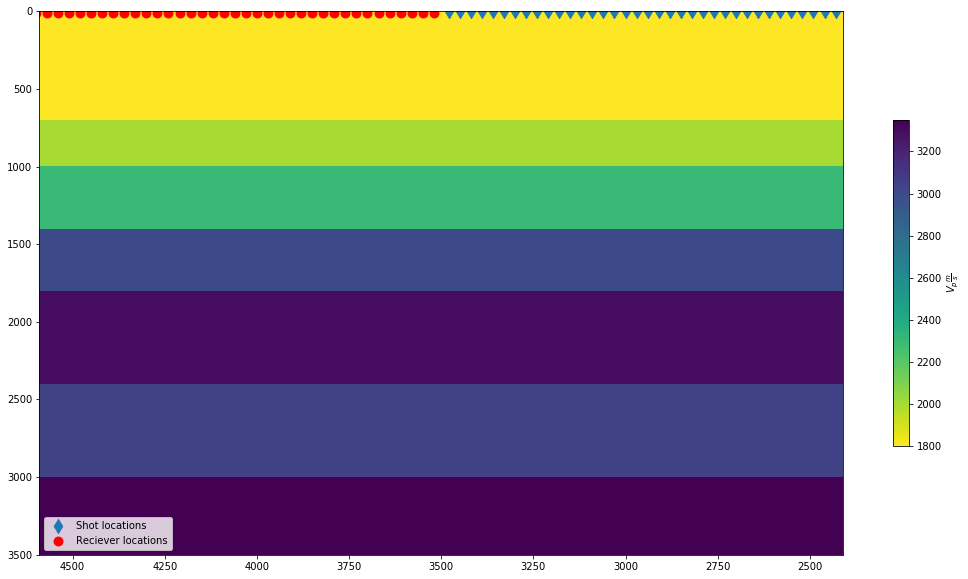

In [13]:
plt.figure(figsize=(18,10))
plt.scatter(shot_loc * dz,np.ones_like(shot_loc), marker='d', s=100, label='Shot locations')
plt.scatter(reciever_loc * dz,np.ones_like(shot_loc)*10, s=80, color='r', label='Reciever locations')
plt.xlim(reciever_loc.max() * dz - dz, shot_loc.min() * dz + dz)
plt.imshow(cmp_vel_mod, extent=[reciever_loc.max() * dz - dz, shot_loc.min() * dz + dz, 3500, 0], 
           aspect='auto', cmap='viridis_r')
plt.colorbar(shrink=0.6, label=r'$V_p \frac{m}{s}$')
plt.legend(loc='lower left', fancybox=True, facecolor='w')

In [14]:
print("Data in the archive:", data.keys())

Data in the archive: ['velocity_model', 'density_model', 'offsets', 'cmp_orig', 'cmp_geom_sprd', 'dz', 'dt', 'reciever_loc', 'shot_loc', 'twt', 'vnmo_trials', 'vnmo_trial_vels']


In [15]:
# cmp_vel_mod = data['velocity_model']
# cmp_density_mod = data['density_model']
# spacing = data['spacing']
# shot_loc = data['shot_loc']
# reciever_loc = data['reciever_loc']
# dt = data['dt']
# offsets = data['offsets']
# cmp_orig = data['cmp']
# cmp_geom_sprd = data['cmp_geom_sprd']
# vnmo_trials = data['vnmo_trials']
# vnmo_trial_vels = data['vnmo_trial_vels']

# lim_geom = np.percentile(cmp_geom_sprd, 99)
# lim_cmp = np.percentile(cmp_orig, 99)
# twt = np.linspace(0,len(cmp_orig) * dt, len(cmp_orig))

Create the known velocity (should be loading this in the future)

In [16]:
def vel_mod():
#     interface_depths = [0, 700, 1000, 1400, 1800, 2200, 2400, 3000]
#     int_vels = [1800, 2000, 2300, 3000, 3300, 3300, 3050, 3350]
    interface_depths = [0, 700, 1000, 1400, 1800, 2400, 3000]
    int_vels = [1800, 2000, 2300, 3000, 3300, 3050, 3350]
    layer_diff = np.diff(interface_depths)
    twt_vel_mod = np.cumsum([(l * 2) / v for v,l in zip(int_vels,layer_diff)])
    twt_vel_mod = np.insert(twt_vel_mod,0,0.)
    shape=(3500,)
    velocity = np.zeros(shape)
    for d,v in zip(interface_depths, int_vels):
#         velocity[int(d // 10):,:] = v
        velocity[d:] = v
    return velocity, twt_vel_mod

### A library of gathers corrected for different constant Vnmo values.

The data archive we loaded contained two items called "vnmo_trial_vels" and "vnmo_trials." These refer to 
We will use this library to do our stacking velocity analysis

In [9]:
velocities = np.arange(1300,4000,50)
vnmo_trial_vels = velocities

In [41]:
shape = (len(cmp_geom_sprd),)
vnmo_collection = np.array([nmo_correction(cmp_geom_sprd, dt, offsets, np.zeros(shape) + v) for v in velocities])

In [42]:
vnmo_trials = vnmo_collection

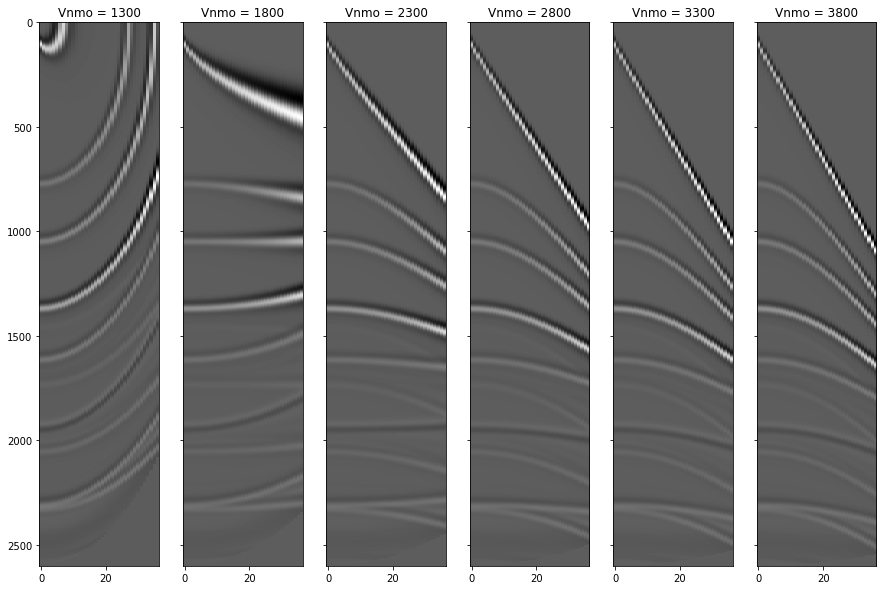

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,10), sharey=True)
for i,j in enumerate(range(0,vnmo_trials.shape[0],vnmo_trials.shape[0] // 5)):
    ax[i].imshow(vnmo_trials[j], aspect = 'auto', cmap='gray')
    ax[i].set_title(f'Vnmo = {vnmo_trial_vels[j]}')
# plt.tight_layout()

In [13]:
# np.savez('C:/Users/goril/OneDrive/_data/cmp_info_2200m.npz', dt=dt, offsets=offsets, cmp=cmp, 
#          cmp_geom_sprd=cmp_geom_sprd, vnmo_trials=vnmo_trials, vnmo_trial_vels=vnmo_trial_vels)

C:\Users\goril\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


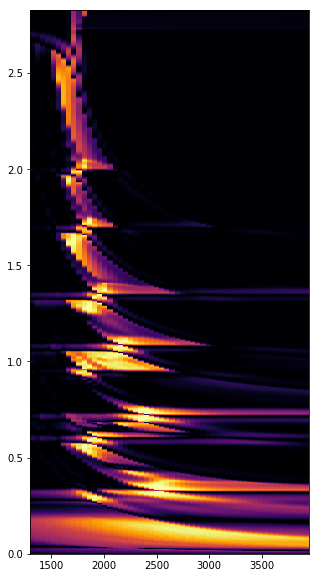

In [11]:
def basic_semblance(vnmo_trials):
    squared_sum = np.array([np.sum(vnmo, axis=1)**2 for vnmo in vnmo_trials])
    summed_squares = np.array([np.sum(vnmo**2, axis=1) for vnmo in vnmo_trials]) 
    n = vnmo_trials.shape[2]

    semblance = (squared_sum / summed_squares) / n
    
    return semblance.T
    
plt.figure(figsize=(5,10))
plt.imshow(basic_semblance(vnmo_trials), aspect='auto', extent=[velocities.min(), velocities.max(), 0 , twt.max()], cmap='inferno')

In [15]:
# interface_depths = [0, 700, 1000, 1400, 1800, 2200, 2400, 3000]
# int_vels = [1800, 2000, 2300, 3000, 3300, 3300, 3050, 3350]
# layer_diff = np.diff(interface_depths)

# twt_vel_mod = [(l * 2) / v for v,l in zip(int_vels,layer_diff)]
# twt_vel_mod = np.cumsum(twt_vel_mod)
# # twt_vel_mod np.insert()
# twt = np.linspace(0, len(cmp) * dt, len(cmp))

NameError: name 'cmp' is not defined

In [ ]:
interface_depths = [0, 700, 1000, 1400, 1800, 2400, 3000]
int_vels = [1800, 2000, 2300, 3000, 3300, 3050, 3350]

velocity, twt_vel_mod = vel_mod()
int_vels = np.array(int_vels)
# twt = np.linspace(0, len(cmp) * dt, len(cmp))
f1 = interp1d(np.append(twt_vel_mod, twt.max()),np.append(int_vels,int_vels[-1]), fill_value='extrapolate')
z = f1(twt)
# np.append(twt_vel_mod, twt.max())
# twt.max()
# plt.plot(z)
plt.figure(figsize=(3,10))
depth = np.linspace(0, len(velocity),len(velocity))
plt.plot(velocity, depth)
plt.gca().invert_yaxis()
plt.scatter(int_vels, interface_depths)


In [ ]:
%matplotlib qt
sem_start = np.array([np.sum(v, axis=1) for v in vnmo_trials])
sns.set_style(style='ticks')

def interact_plot(v0,v1,v2,v3,v4,v5,v6):
    
    real_vel, twt_vel_mod = vel_mod()
    real_vel_twt = time_to_depth(real_vel, real_vel, dt, dz =1)
    real_vel_twt = real_vel_twt[:cmp_geom_sprd.shape[0]]
    
    gain = 8
    titles = ['CMP Gather', 'Semblance Plot', 'NMO Corrected Gather', 'Stacked NMO Corrected Gather']
    x_labels = ['Trace number', r'$V_{nmo}$', 'Trace number', 'Amplitude']
    
    twt = np.linspace(0, len(cmp_orig) * dt, len(cmp_orig))
    v7 = v6
    vnmo_user = np.array([v0,v1,v2,v3,v4,v5,v6,v7])
#     twt = np.linspace(0, len(cmp) * dt, len(cmp))
    f1 = interp1d(np.append(twt_vel_mod, twt.max()),
                  vnmo_user, 
                  fill_value='extrapolate', kind='cubic')
    vnmo_usr_interp = f1(twt)
    c = basic_semblance(vnmo_trials)
    
    nmo_corr = nmo_correction(cmp_geom_sprd, dt, offsets, vnmo_usr_interp)
    
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15,10), sharey=True)
    
    for i,wig in enumerate(cmp_geom_sprd.T):
        ax1.plot(wig * gain + i, twt, 'k')
        ax1.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i > i,
                          interpolate=True, color='k', alpha=0.3)
        ax1.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i < i,
                          interpolate=True, color='r', alpha=0.3)
        
    for i,a in enumerate((ax1,ax2,ax3,ax4)):
        a.set_title(titles[i])
        a.set_xlabel(x_labels[i])
    
    ax1.set_ylabel('TWT (s)')
    ax1.set_ylim(0, twt.max())
    ax1.set_xlim(0,len(cmp_geom_sprd.T))
    
    extent_vnmo = [velocities.min(), velocities.max(), twt.max(), 0]
    ax2.imshow(c, aspect='auto', extent=extent_vnmo, cmap='inferno')
    ax2.plot(vnmo_user, np.append(twt_vel_mod, twt.max()), c='w', marker='.', markersize=15, linewidth=3, markeredgecolor='k')
    ax2.plot(real_vel_twt, twt, '--g', linewidth=3)
    
    for i,wig in enumerate(nmo_corr.T):
        ax3.plot(wig * gain + i, twt, 'k')
        ax3.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i > i,
                          interpolate=True, color='k', alpha=0.3)
        ax3.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i < i,
                          interpolate=True, color='r', alpha=0.3)
    ax3.set_xlim(0,len(cmp_geom_sprd.T))
    
    stk_trace = np.sum(nmo_corr, axis=1)
    ax4.plot(stk_trace, twt, 'k')
    ax4.fill_betweenx(twt, 0, stk_trace, where=stk_trace > 0, color='k', alpha = 0.6)
    ax4.set_xlim(-10,10)
    
    ax1.invert_yaxis()
    
ipw.interact(interact_plot,
            v0=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1700, continuous_update=False),
            v1=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1700, continuous_update=False),
            v2=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1800, continuous_update=False),
            v3=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1900, continuous_update=False),
            v4=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=2100, continuous_update=False),
            v5=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=2000, continuous_update=False),
            v6=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=2500, continuous_update=False))
# ipw.interact(interact_plot,
#             v0=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1700),
#             v1=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1700),
#             v2=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1800),
#             v3=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1900),
#             v4=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=2100),
#             v5=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=2400),
#             v6=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=2500))



In [38]:
%matplotlib inline
sem_start = np.array([np.sum(v, axis=1) for v in vnmo_trials])
sns.set_style(style='ticks')

def interact_plot(v0,v1,v2,v3,v4,v5,v6):
    
    real_vel, twt_vel_mod = vel_mod()
    real_vel_twt = time_to_depth(real_vel, real_vel, dt, dz =1)
    real_vel_twt = real_vel_twt[:cmp_geom_sprd.shape[0]]
    
    gain = 8
    titles = ['CMP Gather', 'Semblance Plot', 'NMO Corrected Gather', 'Stacked NMO Corrected Gather']
    x_labels = ['Trace number', r'$V_{nmo}$', 'Trace number', 'Amplitude']
    
    twt = np.linspace(0, len(cmp_orig) * dt, len(cmp_orig))
    v7 = v6
    vnmo_user = np.array([v0,v1,v2,v3,v4,v5,v6,v7])
#     twt = np.linspace(0, len(cmp) * dt, len(cmp))
    f1 = interp1d(np.append(twt_vel_mod, twt.max()),
                  vnmo_user, 
                  fill_value='extrapolate', kind='cubic')
    vnmo_usr_interp = f1(twt)
    c = basic_semblance(vnmo_trials)
    
    nmo_corr = nmo_correction(cmp_geom_sprd, dt, offsets, vnmo_usr_interp)
    
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15,10), sharey=True)
    
#     for i,wig in enumerate(cmp_geom_sprd.T):
#         ax1.plot(wig * gain + i, twt, 'k')
#         ax1.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i > i,
#                           interpolate=True, color='k', alpha=0.3)
#         ax1.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i < i,
#                           interpolate=True, color='r', alpha=0.3)
    ax1.imshow(cmp_geom_sprd, extent=extent, aspect='auto')
        
    for i,a in enumerate((ax1,ax2,ax3,ax4)):
        a.set_title(titles[i])
        a.set_xlabel(x_labels[i])
    
    ax1.set_ylabel('TWT (s)')
    ax1.set_ylim(0, twt.max())
    ax1.set_xlim(0,len(cmp_geom_sprd.T))
    
    extent_vnmo = [velocities.min(), velocities.max(), twt.max(), 0]
    ax2.imshow(c, aspect='auto', extent=extent_vnmo, cmap='inferno')
    ax2.plot(vnmo_user, np.append(twt_vel_mod, twt.max()), c='w', marker='.', markersize=15, linewidth=3, markeredgecolor='k')
    ax2.plot(real_vel_twt, twt, '--g', linewidth=3)
    
#     for i,wig in enumerate(nmo_corr.T):
#         ax3.plot(wig * gain + i, twt, 'k')
#         ax3.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i > i,
#                           interpolate=True, color='k', alpha=0.3)
#         ax3.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i < i,
#                           interpolate=True, color='r', alpha=0.3)
#     ax3.set_xlim(0,len(cmp_geom_sprd.T))
    ax3.imshow(nmo_corr, extent=extent, aspect='auto')
    
    stk_trace = np.sum(nmo_corr, axis=1)
    ax4.plot(stk_trace, twt, 'k')
    ax4.fill_betweenx(twt, 0, stk_trace, where=stk_trace > 0, color='k', alpha = 0.6)
    ax4.set_xlim(-10,10)
    
    ax1.invert_yaxis()
    
ipw.interact(interact_plot,
            v0=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1700, continuous_update=False),
            v1=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1700, continuous_update=False),
            v2=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1800, continuous_update=False),
            v3=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=1900, continuous_update=False),
            v4=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=2100, continuous_update=False),
            v5=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=2400, continuous_update=False),
            v6=ipw.FloatSlider(min=velocities.min(), max=velocities.max(), step=50, value=2500, continuous_update=False))



interactive(children=(FloatSlider(value=1700.0, continuous_update=False, description='v0', max=3450.0, min=130…

<function __main__.interact_plot>

C:\Users\goril\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


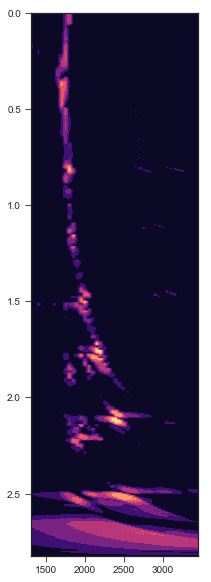

In [48]:
Y = twt
X = velocities

Z = basic_semblance(vnmo_collection)

plt.figure(figsize=(3,10))
interp = interp2d(X,Y,Z, kind='linear')
r = interp(X,Y)
plt.contourf(X,Y,Z, cmap='magma')
plt.gca().invert_yaxis()


0.7777777777777778 * 2890000 - 0.0 * 2890000) / (0.7777777777777778 - 0.0)) = 1700.0
1.0777777777777777 * 3422500 - 0.7777777777777778 * 2890000) / (1.0777777777777777 - 0.7777777777777778)) = 2191.587451039897
1.4256038647342995 * 4000000 - 1.0777777777777777 * 3422500) / (1.4256038647342995 - 1.0777777777777777)) = 2406.1271613667195
1.692270531400966 * 4000000 - 1.4256038647342995 * 4000000) / (1.692270531400966 - 1.4256038647342995)) = 1999.9999999999995
2.05590689503733 * 5760000 - 1.692270531400966 * 4000000) / (2.05590689503733 - 1.692270531400966)) = 3735.0487777244184
2.4493495179881495 * 7290000 - 2.05590689503733 * 5760000) / (2.4493495179881495 - 2.05590689503733)) = 3909.5917866289333


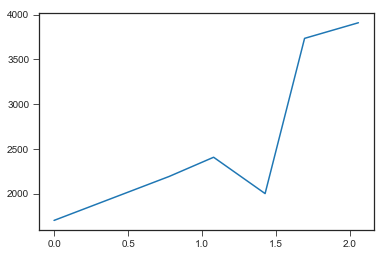

In [324]:
vnmo_user = np.array([1700, 1700, 1850, 2000, 2000, 2400, 2700])

twt = np.linspace(0, len(cmp) * dt, len(cmp))
f1 = interp1d(np.append(twt_vel_mod, twt.max()),
              np.append(vnmo_user,vnmo_user[-1]), 
              fill_value='extrapolate')
vnmo_usr_interp = f1(twt)

# v_int_dix = [(t2 * vrms**2 - t1 * vrms**2) / (t2 - t1)**2 for ]

v_int_dix = [np.sqrt((twt_vel_mod[i+1] * vnmo_user[i+1]**2 - twt_vel_mod[i] * vnmo_user[i]**2) / (twt_vel_mod[i+1] - twt_vel_mod[i])) for i in range(len(vnmo_user)-1)]
plt.plot(twt_vel_mod[:-1], v_int_dix)

for i in range(len(vnmo_user)-1):
    x = np.sqrt((twt_vel_mod[i+1] * vnmo_user[i+1]**2 - twt_vel_mod[i] * vnmo_user[i]**2) / (twt_vel_mod[i+1] - twt_vel_mod[i]))
    print(f'{twt_vel_mod[i+1]} * {vnmo_user[i+1]**2} - {twt_vel_mod[i]} * {vnmo_user[i]**2}) / ({twt_vel_mod[i+1]} - {twt_vel_mod[i]})) = {x}')


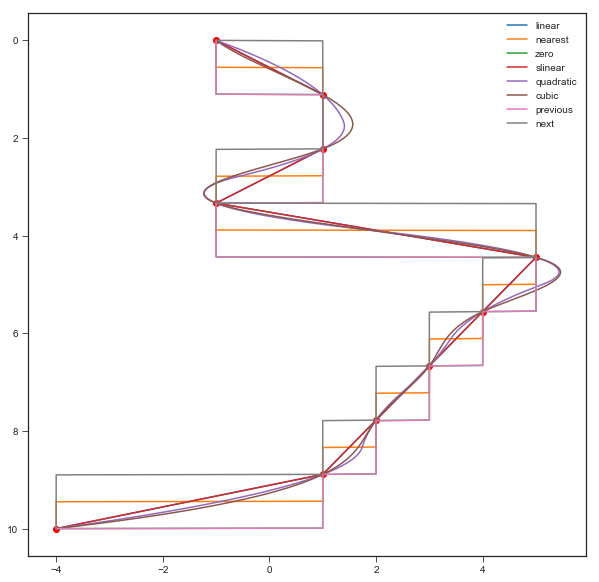

In [391]:
x = np.linspace(0,10,10)
y = np.array([-1,1,1,-1,5,4,3,2,1,-4])

x_new = np.linspace(0,10,1000)

interp_type = ['linear', 'nearest','zero', 'slinear','quadratic', 'cubic','previous', 'next']


    
plt.figure(figsize=(10,10))
for interpl in interp_type:
    z = interp1d(x,y,kind=interpl,)
    zz = z(x_new)
    plt.plot(zz,x_new, label=interpl)
    
plt.scatter(y,x,color='r') 
plt.gca().invert_yaxis()
plt.legend()

In [26]:
%timeit
velocities = np.arange(1800,4300,100)
a = amp_sum(cmp_geom_sprd, dt, offsets, velocities)


In [30]:
# Caltulating the parabolas for all velocities at all 2600 time points within the record
reflect_times = [reflection_time(t0=t, x=offsets, vnmo=vnmo) for vnmo in np.arange(1800,4000,100) for t in twt_2]
# reflect_times = np.where(reflect_times / dt >= 2599, None, reflect_times)
reflect_times = np.array(reflect_times)
reflect_times = np.where(reflect_times / dt > 2599, np.nan, reflect_times)
reflect_times = reflect_times[~np.isnan(reflect_times).any(axis=1)]

amp=np.zeros((len(reflect_times),25))


for k,t in enumerate(reflect_times):
    for i in range(25):
        amp[k][i]= cmp_geom_sprd[int(np.round(t[i] / dt)), i]
#         print('time loc :' + str(i), 'from trace: ' + str(i),t)
# amp_new = np.split(amp, np.arange(0,len(amp), 22))    
        
# plt.imshow(np.sum(amp, axis=1), aspect='auto')

In [31]:
reflect_times = [reflection_time(t0=t, x=offsets, vnmo=vnmo) for vnmo in np.arange(1800,4000,100) for t in twt_2]
reflect_times = np.array(reflect_times)
reflect_times = np.split(reflect_times,2600)
reflect_times = np.array(reflect_times)
len(reflect_times[2])


(55986, 25)

In [13]:
# def amp_sum(cmp, dt, offsets, velocities):

#     amp_sums = np.zeros_like(cmp)
#     nsamples = cmp.shape[0]
#     times = np.arange(0, nsamples*dt, dt)
#     for i, t0 in enumerate(times):
#         for j,v in enumerate(velocities):
#             for k,x in enumerate(offsets):
#                 t = reflection_time(t0, x, v)
#                 amplitude = sample_trace(cmp[:, k], t, dt)
#                 # If the time t is outside of the CMP time range,
#                 # amplitude will be None.
#                 if amplitude is not None:
#                     amp_sums[i, j] = amp_sums[i,j] + amplitude
# #                     print(f'time: {t0}', f'velocity: {v}', f'offset: {x}', 
# #                           f'position: {i},{j}', f'reflection time: {t}', f'amplitude: {amplitude}', f'amp_sums = {amp_sums[i,j]}')
#     return amp_sums